In [1]:
from itertools import product, combinations
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error

from myutils.matplotlib import matplotlib_seaborn_style

matplotlib_seaborn_style()

In [2]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

data['days'] *= -1

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,places_frac,weekday,day_name,weekend,short_term
0,2021-04-12,-1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday,0,1
1,2021-04-13,-1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday,0,1


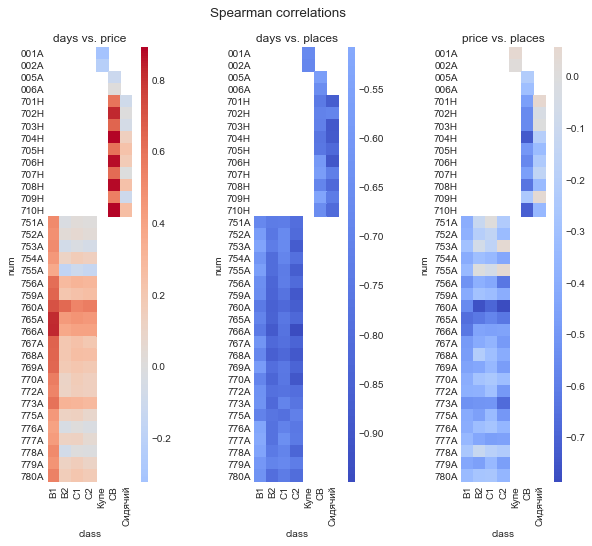

In [3]:
features = ['days', 'price', 'places']
comb = list(combinations(features, 2))

fig, axes = plt.subplots(ncols=len(comb))
fig.set_size_inches(3.5 * len(comb), 8)

for ax, (col1, col2) in zip(axes, comb):
    corr = data.groupby(['num', 'class'])\
        .apply(lambda df: df[[col1, col2]].corr(method='spearman').iloc[0, 1])\
        .reset_index().pivot(index='num', columns='class', values=0)

    sns.heatmap(corr, square=True, ax=ax, cmap='coolwarm', center=0, cbar_kws={'aspect': 60})

    ax.set_title(f'{col1} vs. {col2}')
    
plt.suptitle('Spearman correlations', fontsize=13.5, y=0.95)

plt.savefig('../data/figures/corr_days_price_places.pdf', transparent=True, bbox_inches='tight')

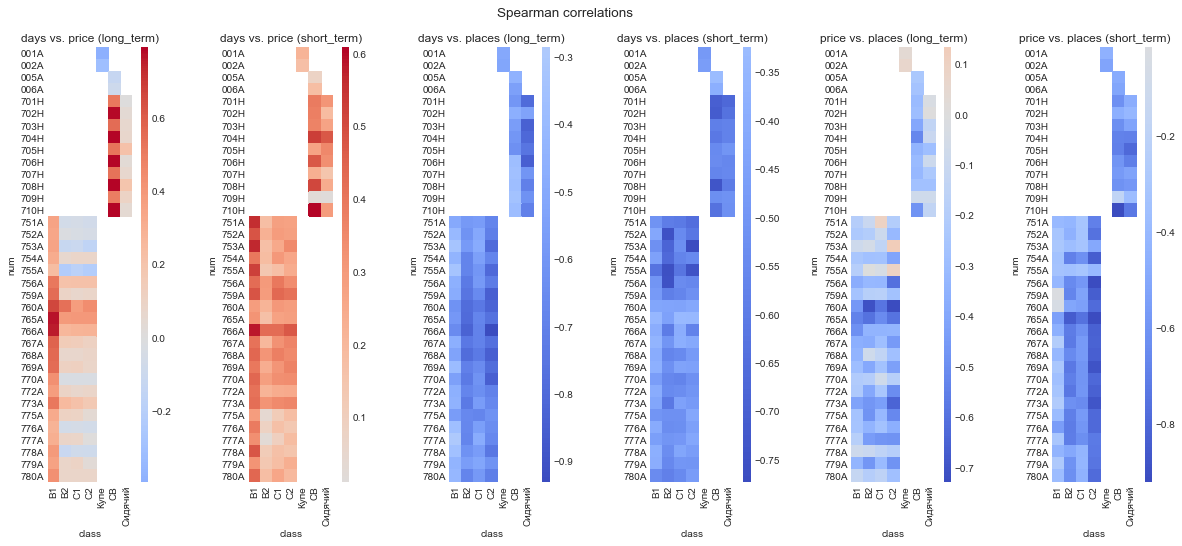

In [16]:
features = ['days', 'price', 'places']
comb = list(combinations(features, 2))

fig, axes = plt.subplots(ncols=len(comb) * 2)
fig.set_size_inches(3.5 * len(comb) * 2, 8)

for i, (col1, col2) in enumerate(comb):
    for j, term in enumerate(['long_term', 'short_term']):
        ax = axes[2 * i + j]
        
        corr = data[data['short_term'] == j].groupby(['num', 'class'])\
            .apply(lambda df: df[[col1, col2]].corr(method='spearman').iloc[0, 1])\
            .reset_index().pivot(index='num', columns='class', values=0)

        sns.heatmap(corr, square=True, ax=ax, cmap='coolwarm', center=0, cbar_kws={'aspect': 60})
        ax.set_title(f'{col1} vs. {col2} ({term})')
    
plt.suptitle('Spearman correlations', fontsize=13.5, y=0.95)

plt.savefig('../data/figures/corr_days_price_places_terms.pdf', transparent=True, bbox_inches='tight')

In [5]:
def nancov(x, y):
    return np.nanmean((x - np.nanmean(x)) * (y - np.nanmean(y)))

In [6]:
def pearson_corr(x, y):
    return nancov(x, y) / np.nanstd(x) / np.nanstd(y)

In [7]:
def simple_regression(x, y):
    b = np.zeros(2)
    b[1] = nancov(x, y) / np.nanvar(x, ddof=0)
    b[0] = np.nanmean(y) - b[1] * np.nanmean(x)
    
    return b

In [8]:
def partial_corr(ar1: np.ndarray, ar2: np.ndarray, b: np.ndarray) -> float:
    b1 = simple_regression(b, ar1)
    b2 = simple_regression(b, ar2)
    
    res1 = ar1 - (b1[0] + b1[1] * b)
    res2 = ar2 - (b2[0] + b2[1] * b)
    
    return pearson_corr(res1, res2)

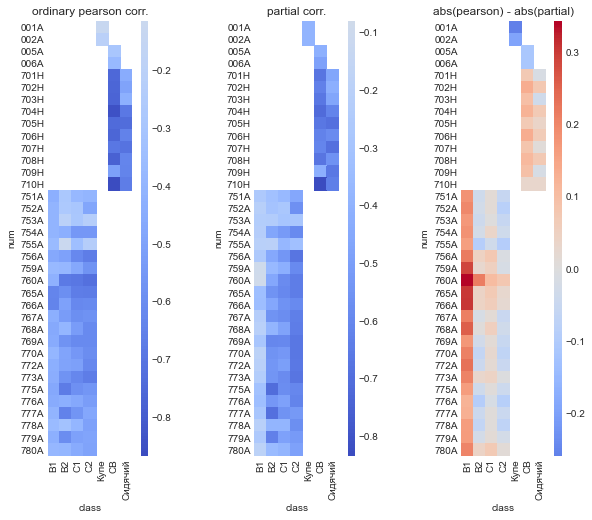

In [9]:
pearson = data.groupby(['num', 'class'])\
    .apply(lambda df: pearson_corr(df['places'], df['price']))\
    .reset_index().pivot(index='num', columns='class', values=0)

partial = data.groupby(['num', 'class'])\
    .apply(lambda df: partial_corr(df['places'], df['price'], df['days']))\
    .reset_index().pivot(index='num', columns='class', values=0)

diff = pearson.abs() - partial.abs()

fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(3.5 * 3, 8)

for ax, d in zip(axes, [pearson, partial, diff]):
    sns.heatmap(d, square=True, center=0, cmap='coolwarm', cbar_kws={'aspect': 60}, ax=ax)
    
axes[0].set_title('ordinary pearson corr.')
axes[1].set_title('partial corr.')
axes[2].set_title('abs(pearson) - abs(partial)')

plt.savefig('../data/figures/corr_pearson_vs_partial.pdf', transparent=True, bbox_inches='tight')

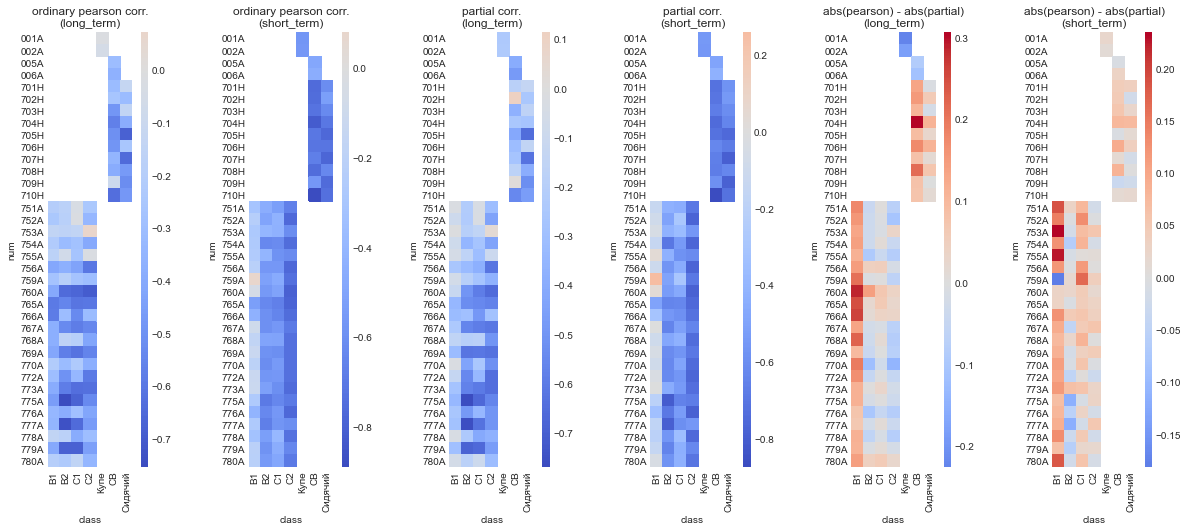

In [10]:
fig, axes = plt.subplots(ncols=6)
fig.set_size_inches(3.5 * 6, 8)

for j, term in enumerate(['long_term', 'short_term']):
    mask = data['short_term'] == j
    
    pearson = data[mask].groupby(['num', 'class'])\
        .apply(lambda df: pearson_corr(df['places'], df['price']))\
        .reset_index().pivot(index='num', columns='class', values=0)

    partial = data[mask].groupby(['num', 'class'])\
        .apply(lambda df: partial_corr(df['places'], df['price'], df['days']))\
        .reset_index().pivot(index='num', columns='class', values=0)

    diff = pearson.abs() - partial.abs()
    
    dfs = [pearson, partial, diff]
    titles = ['ordinary pearson corr.', 'partial corr.', 'abs(pearson) - abs(partial)']
    
    for i, (d, title) in enumerate(zip(dfs, titles)):
        ax = axes[2 * i + j]
    
        sns.heatmap(d, square=True, center=0, cmap='coolwarm', cbar_kws={'aspect': 60}, ax=ax)
        
        ax.set_title(f'{title}\n({term})')
    
plt.savefig('../data/figures/corr_pearson_vs_partial_terms.pdf', transparent=True, bbox_inches='tight')